In [1]:
# pip install transformers

In [2]:
# pip install emoji

### 1. Import packages

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW
import pandas as pd
import torch
import random
import emoji
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import json
from collections import Counter
import re
from string import punctuation
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [4]:
SEED = 9999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

### 2. Tokenizer

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

### 3. Load and clean data

In [6]:
def remove_punct(s):
    punct_pattern = re.compile(r'[^\w\s\#]')
    no_punct = punct_pattern.sub(r'', s)
    return no_punct

In [7]:
def remove_emoji(string):
    allchars = [str for str in string]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI['en']]
    clean_text = ' '.join([str for str in string.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [8]:
def read_data(data, test=False):
    texts = []
    labels = []
    if test == False:
        data.dropna(subset=['tidyTweet', 'Label'], inplace=True)
    else:
        data.dropna(subset=['tidyTweet'], inplace=True)

    for i in tqdm(data.itertuples(), total=len(data)):
        line = getattr(i, 'tidyTweet')
        line = line.strip()
        line = remove_emoji(line)
        line = remove_punct(line).strip()
        texts.append(line)

        if test == False:
            label = getattr(i, 'Label')
            labels.append(label)
            if label == 1.0:
                texts.extend([line] * 2)
                labels.extend([label] * 2)

    if test == False:
        assert len(texts) == len(labels)
        return texts, labels
    else:
        return texts

In [9]:
df = pd.read_csv('../dataset.csv')
df.groupby(['Label']).count()

,id,date,tweet,tidyTweet
Label,,,,
0.0,6206,6206,6206,6205
1.0,2884,2884,2884,2883


In [10]:
texts, labels = read_data(df)

  0%|          | 0/9088 [00:00<?, ?it/s]

In [11]:
Counter(labels)

Counter({0.0: 6205, 1.0: 5766})

### 4. Split train validation dataset

In [12]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, 
                                                                    test_size=0.2, 
                                                                    random_state=43,
                                                                    stratify=labels)

In [13]:
len(train_labels), len(val_labels), len(train_texts), len(val_texts)

(9576, 2395, 9576, 2395)

In [14]:
max([len(item) for item in texts])

286

### 5. Tokenization

In [15]:
train_encodings = tokenizer(train_texts,
                            truncation=True,
                            padding='max_length',
                            max_length=128)
val_encodings = tokenizer(val_texts,
                          truncation=True,
                          padding='max_length',
                          max_length=128)

In [16]:
label_ids = {item: idx for idx, item in enumerate(set(sorted(labels)))}
label_ids

{0.0: 0, 1.0: 1}

### 6. Generate PyTorch dataset

In [17]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        idx = int(idx)
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        if self.labels is not None:
            item['labels'] = torch.tensor(label_ids[self.labels[idx]])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [18]:
train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)

### 7. Dataloader

In [19]:
batch_size = 32
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)
eval_loader = DataLoader(val_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

### 8. Load pretrained model

In [20]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_ids))
model.to(device)
model.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 9. Evaluation

In [21]:
def eval_model(model, eval_loader):
    model.eval()
    labels = []
    preds = []
    eval_loss = 0
    for batch in eval_loader:
        input_ids = batch['input_ids'].to(device)
        batch_labels = batch['labels'].to(device)
        labels.extend(batch['labels'].numpy())
        with torch.no_grad():
            outputs = model(input_ids=input_ids, labels=batch_labels)
        eval_loss += outputs.loss.item()
        preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
    eval_loss = eval_loss / len(val_dataset)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    model.train()
    return accuracy, precision, recall, f1, eval_loss

### 10. Train the model

In [22]:
epoch = 10
lr = 1e-5
path = 'model_best_bert'
best_acc = 0
train_losses = []
eval_stats = {'Epoch':[], 'Loss':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'F1':[]}

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [{'params' : [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                 'weight_decay_rate' : 0.01}, 
                                {'params' : [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                 'weight_decay_rate' : 0.0}]
optim = AdamW(optimizer_grouped_parameters, lr=lr)
writer = SummaryWriter(comment='-bert-ep{}-bs{}-lr{}'.format(epoch, batch_size, lr))

for e in tqdm(range(epoch), desc='Epoch'):
    train_loss = 0
    for idx, batch in tqdm(enumerate(train_loader),
                           total=len(train_texts) // batch_size,
                           desc='Batch'):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_loss = train_loss / len(train_dataset)
    train_losses.append(train_loss)

    accuracy, precision, recall, f1, eval_loss = eval_model(model, eval_loader)
    
    eval_stats['Epoch'].append(e)
    eval_stats['Loss'].append(eval_loss)
    eval_stats['Accuracy'].append(accuracy)
    eval_stats['Precision'].append(precision)
    eval_stats['Recall'].append(recall)
    eval_stats['F1'].append(f1)

    writer.add_scalar('train_loss', train_loss, e)
    writer.add_scalar('dev_accuracy', accuracy, e)
    writer.add_scalar('dev_precision', precision, e)
    writer.add_scalar('dev_recall', recall, e)
    writer.add_scalar('dev_f1', f1, e)

    print(f'Epoch:{e+1}/{epoch}')
    print('Train loss:', train_loss)
    print('Validation loss:', eval_loss)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print()

    if accuracy > best_acc:
        model.save_pretrained(path)
        tokenizer.save_pretrained(path)
        best_acc = accuracy

print('Best Accuracy:', best_acc)
print('Finished Training.')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch:1/10
Train loss: 0.02071902773956906
Validation loss: 0.018320080706371394
Accuracy: 0.6901878914405011
Precision: 0.6988020571012035
Recall: 0.6934842477623988
F1: 0.6888508128338949



Batch:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch:2/10
Train loss: 0.017230478665459226
Validation loss: 0.016537572496370383
Accuracy: 0.7457202505219207
Precision: 0.747197963390875
Recall: 0.743819975225436
F1: 0.7441097909183017



Batch:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch:3/10
Train loss: 0.014004577464776529
Validation loss: 0.015251478328834247
Accuracy: 0.7866388308977036
Precision: 0.7908515490575939
Recall: 0.7887109545748453
F1: 0.7864666946179477



Batch:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch:4/10
Train loss: 0.009228636899693816
Validation loss: 0.016151433965358456
Accuracy: 0.7916492693110647
Precision: 0.8068578540961693
Recall: 0.7955808685621396
F1: 0.7903296973205787



Batch:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch:5/10
Train loss: 0.0058706063824280185
Validation loss: 0.015304848886170815
Accuracy: 0.826722338204593
Precision: 0.8311520404833701
Recall: 0.8288170494806977
F1: 0.8265906492506807



Batch:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch:6/10
Train loss: 0.003496027205360364
Validation loss: 0.015928896401458593
Accuracy: 0.8417536534446765
Precision: 0.8437756169756792
Recall: 0.8431999826829428
F1: 0.841740299650896



Batch:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch:7/10
Train loss: 0.00257664619555577
Validation loss: 0.01605180588731686
Accuracy: 0.8526096033402922
Precision: 0.8527004636060854
Recall: 0.8531590362219768
F1: 0.8525724896029891



Batch:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch:8/10
Train loss: 0.0017990036656999916
Validation loss: 0.019666910038129398
Accuracy: 0.8446764091858038
Precision: 0.8500485386964014
Recall: 0.8469619038707812
F1: 0.8445156939779019



Batch:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch:9/10
Train loss: 0.0013816650262121546
Validation loss: 0.0218438532102332
Accuracy: 0.8367432150313152
Precision: 0.8470606060606061
Recall: 0.8398839058901735
F1: 0.8362305526568496



Batch:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch:10/10
Train loss: 0.0010120453426028728
Validation loss: 0.023150035686059885
Accuracy: 0.8359081419624217
Precision: 0.8466237088384256
Recall: 0.839108478794286
F1: 0.8353615308499364

Finished Training.


In [23]:
train_losses

[0.02071902773956906,
 0.017230478665459226,
 0.014004577464776529,
 0.009228636899693816,
 0.0058706063824280185,
 0.003496027205360364,
 0.00257664619555577,
 0.0017990036656999916,
 0.0013816650262121546,
 0.0010120453426028728]

In [24]:
eval_stats

{'Accuracy': [0.6901878914405011,
  0.7457202505219207,
  0.7866388308977036,
  0.7916492693110647,
  0.826722338204593,
  0.8417536534446765,
  0.8526096033402922,
  0.8446764091858038,
  0.8367432150313152,
  0.8359081419624217],
 'Epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'F1': [0.6888508128338949,
  0.7441097909183017,
  0.7864666946179477,
  0.7903296973205787,
  0.8265906492506807,
  0.841740299650896,
  0.8525724896029891,
  0.8445156939779019,
  0.8362305526568496,
  0.8353615308499364],
 'Loss': [0.018320080706371394,
  0.016537572496370383,
  0.015251478328834247,
  0.016151433965358456,
  0.015304848886170815,
  0.015928896401458593,
  0.01605180588731686,
  0.019666910038129398,
  0.0218438532102332,
  0.023150035686059885],
 'Precision': [0.6988020571012035,
  0.747197963390875,
  0.7908515490575939,
  0.8068578540961693,
  0.8311520404833701,
  0.8437756169756792,
  0.8527004636060854,
  0.8500485386964014,
  0.8470606060606061,
  0.8466237088384256],
 'Recall': [0.6934842

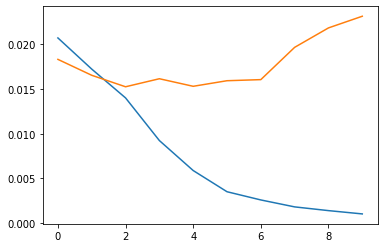

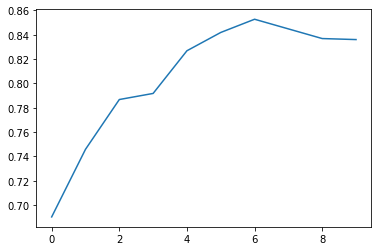

In [35]:
plt.plot(train_losses)
plt.plot(eval_stats['Loss'])
plt.show()

plt.plot(eval_stats['Accuracy'])
plt.show()

In [28]:
# from google.colab import files

# !zip -r /content/model_best_bert.zip /content/model_best_bert
# files.download("/content/model_best_bert.zip")

# !zip -r /content/runs.zip /content/runs
# files.download("/content/runs.zip")

# files.download("/content/bert.log")

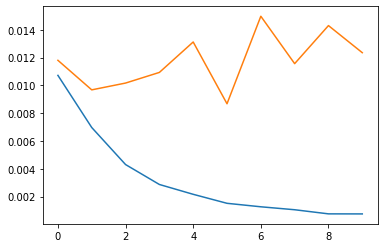

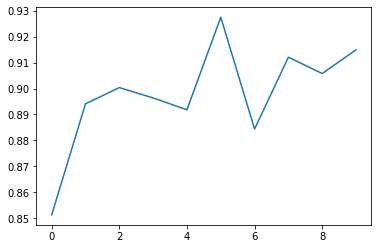

In [34]:
# # 1 这个数据采用原始数据量的数据集 label 0保持不变 label 1增加3
# train_losses1 = [0.010722570272852573,
#  0.0069729289107774515,
#  0.004309510332342772,
#  0.0028761524801474226,
#  0.00216871279100359,
#  0.0015216043603697594,
#  0.0012710981077642886,
#  0.0010590753398056565,
#  0.0007627186893823183,
#  0.0007586327770189432]
# eval_stats1 = {'Accuracy': [0.851270339708821,
#   0.8940907793320011,
#   0.9003711104767342,
#   0.8963745361119041,
#   0.8918070225520982,
#   0.9274907222380816,
#   0.8843848130174137,
#   0.9120753639737368,
#   0.9057950328290038,
#   0.9149300599486154],
#  'Epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
#  'F1': [0.8512579273731794,
#   0.8939663490937828,
#   0.9000709081018738,
#   0.8959258752725157,
#   0.891160424947834,
#   0.9274069483443051,
#   0.8834241243857275,
#   0.9117303638176011,
#   0.9053010567707054,
#   0.914626155444591],
#  'Loss': [0.011805636697144907,
#   0.00968085939254449,
#   0.010169759165158518,
#   0.010935187890121776,
#   0.013123786760972136,
#   0.008681012367254881,
#   0.014975376929125376,
#   0.011566130753873485,
#   0.01430332538018563,
#   0.012354091516755204],
#  'Precision': [0.8512461688815057,
#   0.897178883956256,
#   0.9071691863793234,
#   0.9056190713929106,
#   0.9040192370875492,
#   0.9307548657944916,
#   0.9006266570747694,
#   0.9208530016824412,
#   0.9169992868605221,
#   0.9230648154229618],
#  'Recall': [0.851286477639871,
#   0.8946460882407598,
#   0.9011797058641342,
#   0.8973157086548713,
#   0.8928876956531662,
#   0.9280475598981511,
#   0.8856325942444307,
#   0.9129803507330576,
#   0.9068182336851096,
#   0.9158004296952684]}

# plt.plot(train_losses1)
# plt.plot(eval_stats1['Loss'])
# plt.show()

# plt.plot(eval_stats1['Accuracy'])
# plt.show()

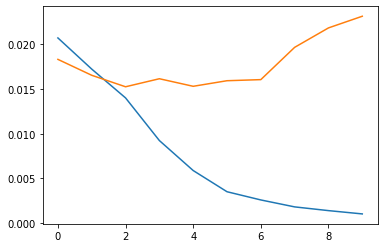

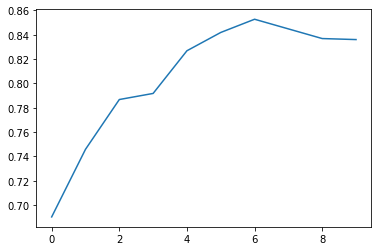

In [37]:
# # 2 这个数据采用减少label 0 增加label 1的数据集
# train_losses2 = [0.02071902773956906,
#  0.017230478665459226,
#  0.014004577464776529,
#  0.009228636899693816,
#  0.0058706063824280185,
#  0.003496027205360364,
#  0.00257664619555577,
#  0.0017990036656999916,
#  0.0013816650262121546,
#  0.0010120453426028728]
# eval_stats2 = {'Accuracy': [0.6901878914405011,
#   0.7457202505219207,
#   0.7866388308977036,
#   0.7916492693110647,
#   0.826722338204593,
#   0.8417536534446765,
#   0.8526096033402922,
#   0.8446764091858038,
#   0.8367432150313152,
#   0.8359081419624217],
#  'Epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
#  'F1': [0.6888508128338949,
#   0.7441097909183017,
#   0.7864666946179477,
#   0.7903296973205787,
#   0.8265906492506807,
#   0.841740299650896,
#   0.8525724896029891,
#   0.8445156939779019,
#   0.8362305526568496,
#   0.8353615308499364],
#  'Loss': [0.018320080706371394,
#   0.016537572496370383,
#   0.015251478328834247,
#   0.016151433965358456,
#   0.015304848886170815,
#   0.015928896401458593,
#   0.01605180588731686,
#   0.019666910038129398,
#   0.0218438532102332,
#   0.023150035686059885],
#  'Precision': [0.6988020571012035,
#   0.747197963390875,
#   0.7908515490575939,
#   0.8068578540961693,
#   0.8311520404833701,
#   0.8437756169756792,
#   0.8527004636060854,
#   0.8500485386964014,
#   0.8470606060606061,
#   0.8466237088384256],
#  'Recall': [0.6934842477623988,
#   0.743819975225436,
#   0.7887109545748453,
#   0.7955808685621396,
#   0.8288170494806977,
#   0.8431999826829428,
#   0.8531590362219768,
#   0.8469619038707812,
#   0.8398839058901735,
#   0.839108478794286]}

# plt.plot(train_losses2)
# plt.plot(eval_stats2['Loss'])
# plt.show()

# plt.plot(eval_stats2['Accuracy'])
# plt.show()

###11. Prediction of test dataset

In [29]:
trained_bert_model = BertForSequenceClassification.from_pretrained(path)
trained_bert_tokenizer = BertTokenizer.from_pretrained(path)
trained_bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [52]:
def test_model(test_data:list, model):
    for data in test_data:
        print(data)
        test_df = pd.read_csv('../' + data)
        test_texts = read_data(test_df, test=True)
        test_encodings = trained_bert_tokenizer(test_texts,
                                truncation=True,
                                padding='max_length',
                                max_length=128)
        test_dataset = Dataset(test_encodings)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model.eval()
        test_predictions = []
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            with torch.no_grad():
                outputs = model(input_ids)
            test_predictions.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())

        test_pred_uniq = np.unique(test_predictions, return_counts=True)
        for l in test_pred_uniq[0]:
            print('Test Label:', l)
            print('Count:', test_pred_uniq[1][np.where(test_pred_uniq[0]==l)].item())
            print('Percentage:', test_pred_uniq[1][np.where(test_pred_uniq[0]==l)].item() / np.sum(test_pred_uniq[1]))
        test_df_labeled = pd.concat((test_df, pd.Series(test_predictions, name='label')), axis=1)
        test_df_labeled.to_csv(data.split('.')[0] + '_labeled.csv', index=False)
        # print(test_df_labeled.head())
        print()

In [53]:
test_data = ['test_truckers_data.csv', 'test_covid_data.csv']
test_model(test_data, trained_bert_model)

test_truckers_data.csv


  0%|          | 0/1803 [00:00<?, ?it/s]

Test Label: 0
Count: 1695
Percentage: 0.940099833610649
Test Label: 1
Count: 108
Percentage: 0.059900166389351084
                    id                 date  \
0  1484312670958342144  2022-01-20 15:51:32   
1  1484277875650048003  2022-01-20 13:33:16   
2  1484248167965020163  2022-01-20 11:35:13   
3  1484247436512006147  2022-01-20 11:32:19   
4  1484237628723503104  2022-01-20 10:53:21   

                                               tweet  \
0  This is what protecting the people looks like....   
1   https://t.co/EbRIfpkeJa HELPING ALL TRUCK DRI...   
2  @hillapaints Everyone join up!! Not just truck...   
3  Breaking: Trudeau asks for #TruckersForFreedom...   
4  Canada this is your LAST CHANCE. If you do not...   

                                           tidyTweet  label  
0  This is what protecting the people looks like....      0  
1    HELPING ALL TRUCK DRIVERS IN NEED #TruckDriv...      0  
2   Everyone join up!! Not just truckers but all ...      0  
3  Breaking: Trude

  0%|          | 0/1935 [00:00<?, ?it/s]

Test Label: 0
Count: 1627
Percentage: 0.8408268733850129
Test Label: 1
Count: 308
Percentage: 0.1591731266149871
                    id                 date  \
0  1484314716897878018  2022-01-20 15:59:40   
1  1484314580067430404  2022-01-20 15:59:07   
2  1484314552560799745  2022-01-20 15:59:01   
3  1484314546235797512  2022-01-20 15:58:59   
4  1484314542620307457  2022-01-20 15:58:58   

                                               tweet  \
0  January 20th, 2022 BC #COVID-19 Pandemic Updat...   
1  Really? #schools #COVID #askteachers  Twice we...   
2  Let’s bust this myth! #Covid19 vaccines don’t ...   
3  'Fox and Friends' continues to promote the lie...   
4  Telehealth State-by-State change tracker as ma...   

                                           tidyTweet  label  
0  January 20th, 2022 BC #COVID-19 Pandemic Updat...      0  
1  Really? #schools #COVID #askteachers  Twice we...      0  
2  Let’s bust this myth! #Covid19 vaccines don’t ...      0  
3  'Fox and Friends

In [31]:
# # 2 这个数据采用减少label 0 增加label 1的数据集
# test_truckers_data.csv
# Test Label: 0
# Count: 1695
# Percentage: 0.940099833610649
# Test Label: 1
# Count: 108
# Percentage: 0.059900166389351084

# test_covid_data.csv
# Test Label: 0
# Count: 1627
# Percentage: 0.8408268733850129
# Test Label: 1
# Count: 308
# Percentage: 0.1591731266149871